# 1. Lecture des données

In [1]:
# -*- coding: utf-8 -*-

import numpy as np
from math import *
from pylab import *

def read_file ( filename ):
    """
    Lit le fichier contenant les données du geyser Old Faithful
    """
    # lecture de l'en-tête
    infile = open ( filename, "r" )
    for ligne in infile:
        if ligne.find ( "eruptions waiting" ) != -1:
            break

    # ici, on a la liste des temps d'éruption et des délais d'irruptions
    data = []
    for ligne in infile:
        nb_ligne, eruption, waiting = [ float (x) for x in ligne.split () ]
        data.append ( eruption )
        data.append ( waiting )
    infile.close ()

    # transformation de la liste en tableau 2D
    data = np.asarray ( data )
    data.shape = ( int ( data.size / 2 ), 2 )

    return data

data = read_file ( "./data/2015_tme4_faithful.txt" )

In [2]:
math.log(math.e)

1.0

# 2. Loi normale bidimensionnelle

In [3]:
def normale_bidim( x,z,quintuplet) :
    import math 
    u_x,u_z,sigma_x,sigma_z,p = quintuplet 
    return 1/(2*math.pi*sigma_x * sigma_z * math.sqrt(1-p**2) )*math.exp(-1/(2*(1-p**2))*(((x-u_x)/sigma_x)**2-2*p*(( (x-u_x)*(z-u_z) )/(sigma_x*sigma_z))+((z-u_z)/sigma_z)**2))

In [4]:
normale_bidim ( 1, 2, (1.0,2.0,3.0,4.0,0) )

0.013262911924324612

In [5]:
normale_bidim ( 1, 0, (1.0,2.0,1.0,2.0,0.7) )

0.0418047994276145

In [6]:
import matplotlib.pyplot as plt

def dessine_1_normale ( params ):
    # récupération des paramètres
    mu_x, mu_z, sigma_x, sigma_z, rho = params

    # on détermine les coordonnées des coins de la figure
    x_min = mu_x - 2 * sigma_x
    x_max = mu_x + 2 * sigma_x
    z_min = mu_z - 2 * sigma_z
    z_max = mu_z + 2 * sigma_z

    # création de la grille
    x = np.linspace ( x_min, x_max, 100 )
    z = np.linspace ( z_min, z_max, 100 )
    X, Z = np.meshgrid(x, z)

    # calcul des normales
    norm = X.copy ()
    for i in range ( x.shape[0] ):
        for j in range ( z.shape[0] ):
            norm[i,j] = normale_bidim ( x[i], z[j], params )

    # affichage
    fig = plt.figure ()
    plt.contour ( X, Z, norm, cmap=cm.autumn )
    plt.show ()

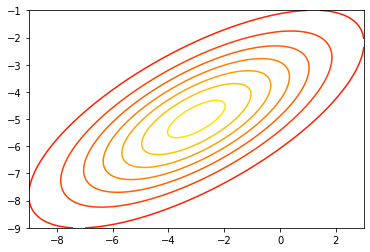

In [7]:
dessine_1_normale ( (-3.0,-5.0,3.0,2.0,0.7) )

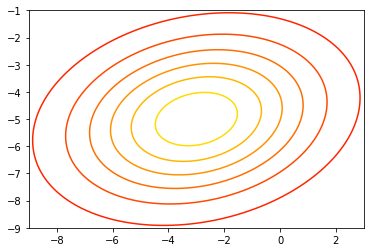

In [8]:
dessine_1_normale ( (-3.0,-5.0,3.0,2.0,0.2) )

# 4. Visualisation des données du Old Faithful

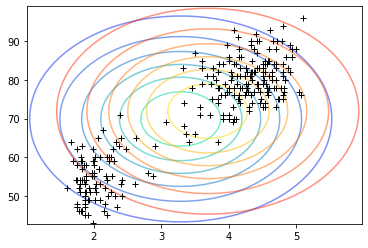

In [9]:
def dessine_normales ( data, params, weights, bounds, ax ):
    # récupération des paramètres
    mu_x0, mu_z0, sigma_x0, sigma_z0, rho0 = params[0]
    mu_x1, mu_z1, sigma_x1, sigma_z1, rho1 = params[1]

    # on détermine les coordonnées des coins de la figure
    x_min = bounds[0]
    x_max = bounds[1]
    z_min = bounds[2]
    z_max = bounds[3]

    # création de la grille
    nb_x = nb_z = 100
    x = np.linspace ( x_min, x_max, nb_x )
    z = np.linspace ( z_min, z_max, nb_z )
    X, Z = np.meshgrid(x, z)

    # calcul des normales
    norm0 = np.zeros ( (nb_x,nb_z) )
    for j in range ( nb_z ):
        for i in range ( nb_x ):
            norm0[j,i] = normale_bidim ( x[i], z[j], params[0] )# * weights[0]
    norm1 = np.zeros ( (nb_x,nb_z) )
    for j in range ( nb_z ):
        for i in range ( nb_x ):
             norm1[j,i] = normale_bidim ( x[i], z[j], params[1] )# * weights[1]

    # affichages des normales et des points du dataset
    ax.contour ( X, Z, norm0, cmap=cm.winter, alpha = 0.5 )
    ax.contour ( X, Z, norm1, cmap=cm.autumn, alpha = 0.5 )
    for point in data:
        ax.plot ( point[0], point[1], 'k+' )


def find_bounds ( data, params ):
    # récupération des paramètres
    mu_x0, mu_z0, sigma_x0, sigma_z0, rho0 = params[0]
    mu_x1, mu_z1, sigma_x1, sigma_z1, rho1 = params[1]

    # calcul des coins
    x_min = min ( mu_x0 - 2 * sigma_x0, mu_x1 - 2 * sigma_x1, data[:,0].min() )
    x_max = max ( mu_x0 + 2 * sigma_x0, mu_x1 + 2 * sigma_x1, data[:,0].max() )
    z_min = min ( mu_z0 - 2 * sigma_z0, mu_z1 - 2 * sigma_z1, data[:,1].min() )
    z_max = max ( mu_z0 + 2 * sigma_z0, mu_z1 + 2 * sigma_z1, data[:,1].max() )

    return ( x_min, x_max, z_min, z_max )


# affichage des données : calcul des moyennes et variances des 2 colonnes
mean1 = data[:,0].mean ()
mean2 = data[:,1].mean ()
std1  = data[:,0].std ()
std2  = data[:,1].std ()

# les paramètres des 2 normales sont autour de ces moyennes
params = np.array ( [(mean1 - 0.2, mean2 - 1, std1, std2, 0),
                     (mean1 + 0.2, mean2 + 1, std1, std2, 0)] )
weights = np.array ( [0.4, 0.6] )
bounds = find_bounds ( data, params )

# affichage de la figure
fig = plt.figure ()
ax = fig.add_subplot(111)
dessine_normales ( data, params, weights, bounds, ax )
plt.show ()

# 5. EM : l'étape E

In [10]:
def Q_i ( data, current_params, current_weights ):
    [[mu_x_0, mu_z_0, sigma_x_0, sigma_z_0, rho_0],[mu_x_1, mu_z_1, sigma_x_1, sigma_z_1, rho_1]] = current_params
    [pi_0,pi_1] = current_weights
    t = list()
    for d in data:
        [x,z] = d
        a_0 = pi_0 * normale_bidim(x,z,(mu_x_0, mu_z_0, sigma_x_0, sigma_z_0, rho_0))
        a_1 = pi_1 * normale_bidim(x,z,(mu_x_1, mu_z_1, sigma_x_1, sigma_z_1, rho_1))
        Q_y0 = a_0/(a_0+a_1)
        Q_y1 = a_1/(a_0+a_1)
        
        t.append(np.array([Q_y0,Q_y1]))
        
    return np.array(t)


In [11]:
#current_params = np.array ( [(mu_x, mu_z, sigma_x, sigma_z, rho),   # params 1ère loi normale
#                             (mu_x, mu_z, sigma_x, sigma_z, rho)] ) # params 2ème loi normale
current_params = np.array([[ 3.28778309, 69.89705882, 1.13927121, 13.56996002, 0. ],
                           [ 3.68778309, 71.89705882, 1.13927121, 13.56996002, 0. ]])

# current_weights = np.array ( [ pi_0, pi_1 ] )
current_weights = np.array ( [ 0.5, 0.5 ] )

T = Q_i ( data, current_params, current_weights )
print(T)

[[0.46939088 0.53060912]
 [0.66899936 0.33100064]
 [0.50349992 0.49650008]
 [0.61489199 0.38510801]
 [0.38336517 0.61663483]
 [0.58880846 0.41119154]
 [0.36370054 0.63629946]
 [0.45319835 0.54680165]
 [0.66597113 0.33402887]
 [0.39678193 0.60321807]
 [0.66674347 0.33325653]
 [0.43178097 0.56821903]
 [0.42637974 0.57362026]
 [0.68892521 0.31107479]
 [0.37635861 0.62364139]
 [0.6484613  0.3515387 ]
 [0.65298434 0.34701566]
 [0.36662753 0.63337247]
 [0.68719135 0.31280865]
 [0.41996736 0.58003264]
 [0.67617442 0.32382558]
 [0.68892521 0.31107479]
 [0.48363046 0.51636954]
 [0.53749981 0.46250019]
 [0.41197248 0.58802752]
 [0.45858658 0.54141342]
 [0.65505529 0.34494471]
 [0.44056782 0.55943218]
 [0.45294617 0.54705383]
 [0.40629466 0.59370534]
 [0.43213395 0.56786605]
 [0.40900976 0.59099024]
 [0.52258721 0.47741279]
 [0.43366997 0.56633003]
 [0.46503453 0.53496547]
 [0.65892553 0.34107447]
 [0.67878225 0.32121775]
 [0.37438794 0.62561206]
 [0.65456976 0.34543024]
 [0.35282612 0.64717388]


In [12]:
current_params = np.array([[ 3.2194684, 67.83748075, 1.16527301, 13.9245876,  0.9070348 ],
                           [ 3.75499261, 73.9440348, 1.04650191, 12.48307362, 0.88083712]])
current_weights = np.array ( [ 0.49896815, 0.50103185] )
T = Q_i ( data, current_params, current_weights )
print(T)

[[0.44352868 0.55647132]
 [0.70465534 0.29534466]
 [0.47692866 0.52307134]
 [0.61531052 0.38468948]
 [0.38502072 0.61497928]
 [0.58493721 0.41506279]
 [0.37621272 0.62378728]
 [0.42185109 0.57814891]
 [0.70665534 0.29334466]
 [0.39346396 0.60653604]
 [0.70167538 0.29832462]
 [0.41383928 0.58616072]
 [0.40975898 0.59024102]
 [0.74656919 0.25343081]
 [0.37669861 0.62330139]
 [0.67922662 0.32077338]
 [0.65636463 0.34363537]
 [0.37135623 0.62864377]
 [0.73399065 0.26600935]
 [0.40550488 0.59449512]
 [0.7213767  0.2786233 ]
 [0.74656919 0.25343081]
 [0.45501587 0.54498413]
 [0.51582119 0.48417881]
 [0.38523308 0.61476692]
 [0.42949663 0.57050337]
 [0.6836669  0.3163331 ]
 [0.42010952 0.57989048]
 [0.43210955 0.56789045]
 [0.39352601 0.60647399]
 [0.4049539  0.5950461 ]
 [0.3914101  0.6085899 ]
 [0.49984226 0.50015774]
 [0.41723141 0.58276859]
 [0.4416097  0.5583903 ]
 [0.69482148 0.30517852]
 [0.72988155 0.27011845]
 [0.3666247  0.6333753 ]
 [0.67090708 0.32909292]
 [0.37243493 0.62756507]


# 6. EM : l'étape M

In [13]:
math.sqrt(4)

2.0

In [14]:
def M_step (data, Q, current_params, current_weights ):
    pi_0 = Q[:,0].sum() / (Q[:,0].sum()+Q[:,1].sum())
    
    mu_x0 = (Q[:,0]*data[:,0]).sum()/Q[:,0].sum() 
    mu_z0 = (Q[:,0]*data[:,1]).sum()/Q[:,0].sum() 
    
    sigma_x0 =  math.sqrt((Q[:,0]*((data[:,0]-mu_x0)**2)).sum()/Q[:,0].sum())
    sigma_z0 =  math.sqrt((Q[:,0]*((data[:,1]-mu_z0)**2)).sum()/Q[:,0].sum() )
    
    p_0 = ((((data[:,0]-mu_x0)*(data[:,1]-mu_z0))/(sigma_x0*sigma_z0))*(Q[:,0])).sum()/Q[:,0].sum()
    
    ##############################################################################################
    
    pi_1 = Q[:,1].sum() / (Q[:,0].sum()+Q[:,1].sum())

    mu_x1 = (Q[:,1]*data[:,0]).sum()/Q[:,1].sum() 
    mu_z1 = (Q[:,1]*data[:,1]).sum()/Q[:,1].sum() 
    
    sigma_x1 =  math.sqrt((Q[:,1]*((data[:,0]-mu_x1)**2)).sum()/Q[:,1].sum())
    sigma_z1 =  math.sqrt((Q[:,1]*((data[:,1]-mu_z1)**2)).sum()/Q[:,1].sum() )
    
    p_1 = ((((data[:,0]-mu_x1)*(data[:,1]-mu_z1))/(sigma_x1*sigma_z1))*(Q[:,1])).sum()/Q[:,1].sum()
    
    
    return np.array([np.array([mu_x0,mu_z0,sigma_x0,sigma_z0,p_0]),np.array([mu_x1,mu_z1,sigma_x1,sigma_z1,p_1])]),np.array([pi_0,pi_1])

In [15]:
current_params = array([(2.51460515, 60.12832316, 0.90428702, 11.66108819, 0.86533355),
                        (4.2893485,  79.76680985, 0.52047055,  7.04450242, 0.58358284)])
current_weights = array([ 0.45165145,  0.54834855])
Q = Q_i ( data, current_params, current_weights )
n = M_step ( data, Q, current_params, current_weights )
n

(array([[ 2.33418412, 58.06784269,  0.74224878, 10.17591317,  0.82161824],
        [ 4.33880698, 80.36132657,  0.37819574,  5.71033527,  0.3008745 ]]),
 array([0.42453067, 0.57546933]))

In [16]:
mean1 = data[:,0].mean ()
mean2 = data[:,1].mean ()
std1  = data[:,0].std ()
std2  = data[:,1].std ()
params = np.array ( [(mean1 - 0.2, mean2 - 1, std1, std2, 0),
                     (mean1 + 0.2, mean2 + 1, std1, std2, 0)] )
weights = np.array ( [ 0.5, 0.5 ] )
res_EM = list()
for i in range(0,20):
    res_EM.append((params,weights))
    T = Q_i ( data, params, weights )    
    params,weights = M_step ( data, T, params, weights )

In [17]:
plt.rcParams['animation.ffmpeg_path'] = u'/home/ghiles/anaconda3/envs/breakout/bin/ffmpeg'    

step animate = 0
step animate = 0
step animate = 1
step animate = 2
step animate = 3
step animate = 4
step animate = 5
step animate = 6
step animate = 7
step animate = 8
step animate = 9
step animate = 10
step animate = 11
step animate = 12
step animate = 13
step animate = 14
step animate = 15
step animate = 16
step animate = 17
step animate = 18
step animate = 19
step animate = 0


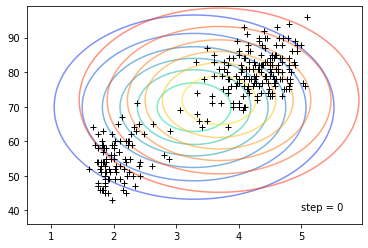

In [18]:
import matplotlib.animation as manimation; manimation.writers.list()
# calcul des bornes pour contenir toutes les lois normales calculées
def find_video_bounds ( data, res_EM ):
    bounds = np.asarray ( find_bounds ( data, res_EM[0][0] ) )
    for param in res_EM:
        new_bound = find_bounds ( data, param[0] )
        for i in [0,2]:
            bounds[i] = min ( bounds[i], new_bound[i] )
        for i in [1,3]:
            bounds[i] = max ( bounds[i], new_bound[i] )
    return bounds

bounds = find_video_bounds ( data, res_EM )


import matplotlib.animation as animation

# création de l'animation : tout d'abord on crée la figure qui sera animée
fig = plt.figure ()
ax = fig.gca (xlim=(bounds[0], bounds[1]), ylim=(bounds[2], bounds[3]))

# la fonction appelée à chaque pas de temps pour créer l'animation
def animate ( i ):
    ax.cla ()
    dessine_normales (data, res_EM[i][0], res_EM[i][1], bounds, ax)
    ax.text(5, 40, 'step = ' + str ( i ))
    print ("step animate = %d" % ( i ))

# exécution de l'animation
anim = animation.FuncAnimation(fig, animate,frames = len(res_EM), interval=1000 )
writer = animation.FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)

# éventuellement, sauver l'animation dans une vidéo
anim.save('old_faithful.mp4',  writer=writer)